## Randwertaufgaben (boundary value problems)

Randwertaufgaben sind eine in der Strömungsmechanik wichtige Klasse von Problemstellungen, bei denen Lösungen zu (partiellen) Differentialgleichungen gesucht werden, die auf den Rändern vorgegebene Werte erfüllen.

Zur numerischen Lösung dieser Problemstellungen existieren mehrere Verfahren, von denen hier das sog. [Schießverfahren](https://de.wikipedia.org/wiki/Schießverfahren) (shooting method) und das [Finite-Differenzen-Verfahren](https://de.wikipedia.org/wiki/Finite-Differenzen-Methode) (FDM) behandelt werden. Weitere Verfahren sind das [Finite-Elemente-Verfahren](https://de.wikipedia.org/wiki/Finite-Elemente-Methode) und das [Finite-Volumen-Verfahren](https://de.wikipedia.org/wiki/Finite-Volumen-Verfahren). Letzteres wird in der Vorlesung "Numerische Strömungssimulation II" ausführlich behandelt.

Als einfaches Beispiel dient eine ebene, druckgradient getriebene Poiseuille-Strömung zwischen zwei parallelen Platten (Spaltströmung):

![](Poiseuille.png)

Für diesen Fall vereinfacht sich die Navier-Stokes-Gleichung zu folgender Differentialgleichung:

$$\frac{\text{d}^2 u}{\text{d}y^2} = \frac{1}{\mu}\frac{\text{d}p}{\text{d}x}$$

mit der Viskosität $\mu$ und den Randwerten $u(y=0) = 0$ und $u(y=H) = 0$, d.h. mit der Haftbedingung an den Wänden.

Für das Beispiel verwenden wir einen Plattenabstand $H = 0,1$, eine Viskosität $\mu = 5$ und einen Druckgradienten $\text{d}p/\text{d}x = -200$.

### Das Schießverfahren (shooting method)

Idee des Schießverfahrens ist es, das Randwertproblem wie ein Anfangswertproblem zu behandeln. D.h. die Randbedingungen können nur an einem Rand ("Anfang") in Form von "Anfangswerten" vorgegeben werden. 

Zur Lösung der DGL 2. Ordnung mit dem Schießverfahren wird diese, wie zuvor bei den Anfangswertproblemen, in ein System gewöhnlicher Differentialgleichungen umgewandelt, mit:

$$u_1 = u, \qquad u_2 = u_1', \qquad u_2' = u_1''$$

$$\frac{\text{d}u_1}{\text{d}y} = u_2$$

$$\frac{\text{d}u_2}{\text{d}y} = \frac{1}{\mu}\frac{\text{d}p}{\text{d}x}$$

und den Randwerten $u_1(y=0) = 0$ und $u_1(y=H) = 0$.

Um das DGL-System mit den bekannten Methoden (Euler-, Runge-Kutta-Verfahren, ...) zu lösen, werden die Anfangswerte $u_1(y=0)$ und $u_2(y=0)$ benötigt. Da $u_2(y=0)$ nicht bekannt ist, wird dafür zunächst ein Wert angenommen, die Lösung berechnet und überprüft, ob der zweite Randwert $u_1(y=H) = 0$ getroffen wird. Ist dies nicht der Fall wird die Schätzung für $u_2(y=0)$ angepasst und erneut eine Lösung berechnet. Der Vorgang wird solange wiederholt, bis der zweite Randwert getroffen wird.

Die Bezeichnung Schießverfahren resultiert daraus, dass das Verfahren an das Einschießen in der Artillerie erinnert.

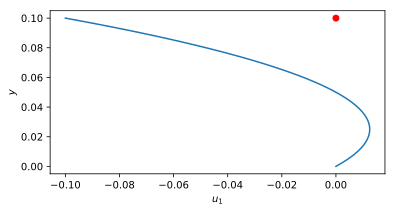

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# das Differentialgleichungssystem mit dem Vektor U=(u1, u2)
# die Funktion gibt einen Vektor mit den Ableitungen zurück.
def DGLSystem(U, y):
    u1, u2 = U
    mu = 5.0
    dpdx = -200.0
    du1dy = u2
    du2dy = dpdx / mu
    return [du1dy, du2dy]

# Randwerte (gegeben)
u1_0 = 0.0
u1_H = 0.0
H    = 0.1

# Randwert (geschätzt)
u2_0 = 1.0

# diskrete y-Werte (hier 50 über die Spalthöhe)
yi = np.linspace(0, H, num=50)

# Lösen des gewöhnlichen DGL-Systems 
# (wir verwenden hier eine in SciPy vorhandene Funktion
# anstatt der zuvor selbst entwickelten)
U = odeint(DGLSystem, [u1_0, u2_0], yi)

# Verlauf von u_1 darstellen
plt.figure(figsize=(6, 3))
plt.plot(U[:,0], yi)
plt.plot([u1_H], [H], 'ro')
plt.xlabel('$u_1$')
plt.ylabel('$y$')
plt.show();

Die Schätzung des Randwerts $u_2(0)$ lässt sich natürlich auch automatisieren.
Eine sehr einfache Möglichkeit ist die Anpassung des Randwertes in Abhängigkeit von der berechneten Abweichung:

Es wurden  11  Iterationen benötigt.


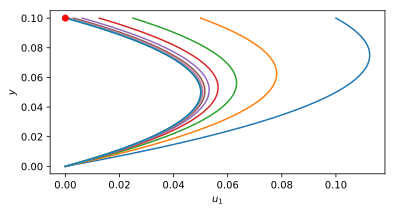

In [9]:
# Vorgegebene Toleranz
tol = 0.0001
faktor = 5.0
iterationen = 0

# Randwerte (gegeben)
u1_0 = 0.0
u1_H = 0.0
H    = 0.1

# Randwert (geschätzt)
u2_0 = 3

# Lösen des gewöhnlichen DGL-Systems 
# (wir verwenden hier eine in SciPy vorhandene Funktion
# anstatt der zuvor selbst entwickelten)
fehler = 2 * tol

plt.figure(figsize=(6, 3))

while abs(fehler) > tol and iterationen < 100:
    U = odeint(DGLSystem, [u1_0, u2_0], yi)
    plt.plot(U[:,0], yi)
    fehler = (u1_H - U[-1,0])
    u2_0 = u2_0 + fehler * faktor
    iterationen += 1

print ("Es wurden ", iterationen, " Iterationen benötigt.")

# Verlauf von u_1 darstellen
#plt.plot(U[:,0], yi)
plt.plot([u1_H], [H], 'ro')
plt.xlabel('$u_1$')
plt.ylabel('$y$')
plt.show();

### Das Finite-Differenzen-Verfahren

Ziel des Finite-Differenzen-Verfahrens ist die Überführung der (partiellen) Differentialgleichung bzw. des DGL-Systems in ein algebraisches Gleichungssystem. Das Verfahren berechnet für diskrete Werte der unabhängigen Variablen (in unserem Beispiel die Koordinate $y$) diskrete angenäherte Werte für die gesuchte Funktion.

#### Berechnung der Ableitungen

Die in der Differentialgleichung auftretenden Ableitungen müssen also zunächst in algebraische Ausdrücke überführt werden. Hierzu bietet sich eine Taylorreihenentwicklung der gesuchten Funktion an. Kennt man den Funktionswert $f(x)$ an der Stelle $x$, so lässt sich der dieser auch an den Stellen $x+\Delta x$ und $x-\Delta x$ mit einer Taylorreihe berechnen:

$$f(x+\Delta x) = f(x) + \frac{\Delta x}{1!}f'(x) + \frac{\Delta x^2}{2!}f''(x) + \dots$$
$$f(x-\Delta x) = f(x) - \frac{\Delta x}{1!}f'(x) + \frac{\Delta x^2}{2!}f''(x) - \dots$$

Löst man die erste der beiden Taylorreihen nach $f'(x)$ auf, erhält man den Ausdruck

$$f'(x) = \frac{f(x+\Delta x) - f(x)}{\Delta x} - \frac{\Delta x}{2!}f''(x) - \dots$$

Bzw. bei Abbruch der Taylorreihe nach dem zweiten Glied ergibt sich der *rechtsseitige Differenzenquotient* mit der Fehlerordnung $\mathcal O(\Delta x)$:

$$f'(x) = \frac{f(x+\Delta x) - f(x)}{\Delta x} + \mathcal O(\Delta x)$$

Auf die gleiche Weise, aber mit der zweiten Taylorreihe von oben ergibt sich der *linksseitige Differenzenquotient* mit derselben Fehlerordnung:

$$f'(x) = \frac{f(x)-f(x-\Delta x)}{\Delta x} + \mathcal O(\Delta x)$$

Eine genauere Formulierung mit der Fehlerordnung $\mathcal O(\Delta x^2)$ erhält man mit dem *zentralen Differenzenquotienten*, der sich durch die Subtraktion der beiden Taylorreihen ergibt:

$$f'(x) = \frac{f(x+\Delta x)-f(x-\Delta x)}{2\Delta x} + \mathcal O(\Delta x^2)$$

Im Beispiel oben wird auch die zweite Ableitung benötigt. Der zentrale Differenzenquotient für die zweite Ableitung ergibt sich aus der Addition der beiden Taylorreihen von oben:

$$f''(x) = \frac{f(x+\Delta x) - 2f(x) + f(x-\Delta x)}{\Delta x^2} + \mathcal O(\Delta x^2)$$

Höhere Ableitungen lassen sich auf die gleiche Weise durch Addition oder Subtraktion der beiden Taylorreihen mit entsprechend vielen Gliedern höherer Ordnung finden.

#### Diskretisierung

Um zur Finite-Differenzen-Formulierung zu kommen, wird das Rechengebiet (in unserem Fall die Strecke zwischen unterer und oberer Platte des Kanals) in $N$ einzelne Punkte zerlegt. Die Punkte können äquidistant oder beliebig angeordnet werden und die Diskretisierung kann natürlich auch in der Fläche (2D) oder im Raum (3D) erfolgen. Zur Demonstration des Verfahrens wählen wir der Einfachheit halber eine äquidistante eindimensionale Verteilung.

![](Poiseuille_diskret.png)

Für jeden der inneren Gitterpunkte (hier $i = 1 \dots 3$) muss die Differentialgleichung für die Poiseuille-Strömung

$$\frac{\text{d}^2 u}{\text{d}y^2} = \frac{1}{\mu}\frac{\text{d}p}{\text{d}x}$$

erfüllt sein. Mithilfe des Differenzenquotienten für die zweite Ableitung lässt sich dann die folgende algebraische Gleichung formulieren:

$$\frac{u_{i+1} - 2 u_i + u_{i-1}}{\Delta y^2} = \frac{1}{\mu}\frac{\text{d}p}{\text{d}x} \qquad \text{für} \qquad i=1 \dots N-1$$

bzw. durch Umstellen:

$$-u_{i-1} + 2 u_i - u_{i+1} = -\Delta y^2 \cdot \frac{1}{\mu}\frac{\text{d}p}{\text{d}x}\qquad \text{für} \qquad i=1 \dots N-1$$

##### Dirichlet-Randbedingung (Vorgabe des Funktionswerts am Rand)

In unserem Beispiel sind die Werte der Geschwindigkeit am oberen ($u_N$) und unteren ($u_0$) Rand gegeben. Man spricht in diesem Fall von sog. Dirichlet-Randbedingungen. Die Gleichung für den ersten Punkt im Strömungsgebiet ($i=1$) wird damit zu:

$$-u_0 + 2 u_1 - u_2 = -\Delta y^2 \cdot \frac{1}{\mu}\frac{\text{d}p}{\text{d}x}$$

wobei die bekannten Größen auf die rechte Seite geschrieben werden:

$$2 u_1 - u_2 = -\Delta y^2 \cdot \frac{1}{\mu}\frac{\text{d}p}{\text{d}x} + u_0$$

Die gleiche Vorgehensweise führt zur Gleichung für den Gitterpunkt an der Stelle $N-1$:

$$-u_{N-2} + 2 u_{N-1}  = -\Delta y^2 \cdot \frac{1}{\mu}\frac{\text{d}p}{\text{d}x} + u_{N}$$

Auch andere Randbedingungen, wie z.B. die Vorgabe eines Geschwindigkeitsgradienten an der Wand (Neumann-Randbedingung) oder die Vorgabe einer Symmetrie sind möglich. Dazu gleich mehr.

##### Lineares Gleichungssystem

Zunächst sollen die algebraischen Gleichungen für jeden Gitterpunkt jedoch in einer Matrix-Vektor-Form dargestellt werden. Mit dem Quellterm $s_i = -\frac{1}{\mu}\frac{\text{d}p}{\text{d}x}$ ergibt sich dann das lineare Gleichungssystem:

$$
\underbrace{
    \begin{pmatrix}
     2      & -1     &  0     & \dots  \\
    -1      &  2     & \ddots & 0      \\
     0      & \ddots & \ddots & -1     \\
     \vdots &  0     & -1     & 2      \\
    \end{pmatrix}
}_{\text{Koeffizientenmatrix}}
\underbrace{
    \begin{pmatrix}
    u_1 \vphantom{\dots} \\
    u_2 \vphantom{\ddots} \\
    \vdots \vphantom{\ddots} \\
    u_{N-1} \vphantom{\vdots}
    \end{pmatrix}
}_{\text{Lösungsvektor}}
=
\underbrace{
    \begin{pmatrix}
    \Delta y^2 \cdot s_1 + u_0 \vphantom{\dots}\\
    \Delta y^2 \cdot s_2 \vphantom{\ddots} \\
    \vdots \vphantom{\ddots} \\
    \Delta y^2 \cdot s_{N-1} + u_N \vphantom{\vdots}
    \end{pmatrix}
}_{\text{Quellvektor}}
$$ 

##### Neumann-Randbedingung (Vorgabe des Gradienten an der Wand)

Eine weitere mögliche Randbedingung wäre die Vorgabe der Schubspannung an der Wand ($\tau_w$, hier für den unteren Rand) anstatt der Geschwindigkeit. Mit dem [Newton'schen Schubspannungsansatz](https://de.wikipedia.org/wiki/Newtonsches_Fluid) ist

$$\tau_w = \mu \frac{\text{d}u}{\text{d}y}\bigg|_w $$

bzw. durch Umstellung und unter Verwendung des zentralen Differenzenquotienten und des fiktiven Punktes bei $i=-1$:

![](Poiseuille_Neumann.png)

$$\frac{\text{d}u}{\text{d}y}\bigg|_w \approx \frac{u_1-u_{-1}}{2\Delta y} = \frac{\tau_w}{\mu}$$

Da in der Gleichung die Geschwindigkeit an der Wand $u_0$ nicht vorkommt und diese aber unbekannt ist, muss nach dem oben gezeigten Schema auch eine algebraische Gleichung für $i=0$ aufgestellt werden:

$$\frac{u_{-1} - 2 u_0 + u_{1}}{\Delta y^2} = \frac{1}{\mu}\frac{\text{d}p}{\text{d}x}$$

Auflösen der vorletzten Gleichung nach $u_{-1}$ und Einsetzen in die letzte Gleichung ergibt:

$$2 u_0 - 2 u_1 = -\Delta y^2 \cdot \frac{1}{\mu} \frac{\text{d}p}{\text{d}x} - \Delta y \cdot \frac{2 \tau_w}{\mu}$$

Als Gleichungssystem ergibt sich nun, wenn wir nur den unteren Rand gegen eine Neumann-Randbedingung tauschen:

$$\begin{pmatrix}
      2    & -2      & 0      &        &        \\
     -1    &  2      & -1     & \ddots &        \\
      0    & -1      &  2     & \ddots & 0      \\
           & \ddots  & \ddots & \ddots & -1     \\
           &         &  0     & -1     & 2      \\
\end{pmatrix}
\begin{pmatrix}
    u_0 \vphantom{\dots} \\
    u_1 \vphantom{\dots} \\
    u_2 \vphantom{\ddots} \\
    \vdots \vphantom{\ddots} \\
    u_{N-1} \vphantom{\vdots}
\end{pmatrix}
=
\begin{pmatrix}
        \Delta y^2 \cdot s_0 - \Delta y \cdot 2 \tau_w / \mu\\
        \Delta y^2 \cdot s_1 \\
        \vdots  \\
        \vdots  \\
        \Delta y^2 \cdot s_{N-1} + u_N \vphantom{\vdots}
\end{pmatrix}$$ 

Die Matrix-Vektor-Gleichung hat also einen zusätzlichen Eintrag aufgrund der Neumann-Randbedingung.

#### Lösung des Gleichungssystems

Bei der Diskretisierung vieler Transportgleichungen ([Wärmeleitungsgleichung](https://de.wikipedia.org/wiki/Wärmeleitungsgleichung), [Konvektions-Diffusions-Gleichung](https://de.wikipedia.org/wiki/Konvektions-Diffusions-Gleichung) oder unser obiges Beispiel) resultiert eine schwach besetzte Koeffizientenmatrix. D.h. ein Großteil der Koeffizienten ist Null. In vielen Fällen sind sogar nur die drei mittleren Diagonalen mit Werten ungleich Null besetzt. Man spricht dann von einer [Tridiagonalmatrix](https://de.wikipedia.org/wiki/Tridiagonalmatrix).  


##### Der Thomas-Algorithmus (Tridiagonalmatrix-Algorithmus - TDMA)

Entspricht die Koeffizientenmatrix einer Tridiagonalmatrix,

$$\begin{pmatrix}
     b_1    &  c_1      & 0      &        &        \\
     a_2    &  b_2      & c_2     & \ddots &        \\
      0    & a_3      &  b_3     & \ddots & 0      \\
           & \ddots  & \ddots & \ddots & c_{N-1}     \\
           &         &  0     & a_n     & b_n      \\
\end{pmatrix}
\begin{pmatrix}
    u_0 \vphantom{\dots} \\
    u_1 \vphantom{\dots} \\
    u_2 \vphantom{\ddots} \\
    \vdots \vphantom{\ddots} \\
    u_{n-1} \vphantom{\vdots}
\end{pmatrix}
=
\begin{pmatrix}
        d_1 \\
        d_2 \\
        d_3  \\
        \vdots  \\
        d_n
\end{pmatrix}$$ 

kann ein sehr effizientes direktes (d.h. nicht iteratives) Lösungsverfahren, der sog. [Thomas-Algorithmus](https://de.wikipedia.org/wiki/Thomas-Algorithmus), verwendet werden.

Der Algorithmus besteht aus zwei Schleifendurchläufen. In einem ersten werden die Koeffizienten wie folgt modifiziert:

$$c_i' = 
\begin{cases}
\frac{c_1}{b_1} & i = 1 \\
\frac{c_i}{b_i - c_{i-1}' a_i} & i = 2, \dots, n-1
\end{cases}$$

$$d_i' = 
\begin{cases}
\frac{d_1}{b_1} & i = 1 \\
\frac{d_i-d_{i-1}' a_i}{b_i - c_{i-1}' a_i} & i = 2, \dots, n
\end{cases}$$

In einem zweiten Durchlauf, der rückwärts erfolgt, ergibt sich die Lösung durch:

$$u_i = 
\begin{cases}
d_n' & i = n \\
d_i' - c_i' u_{i+1} & i = n-1, n-2, \dots, 1
\end{cases}$$

#### Implementierung in Python

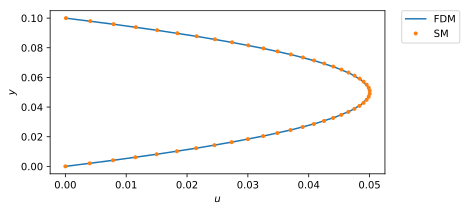

In [12]:
# Randwerte (hier nur Dirichlet-Randbedingung)
u1_0 = 0.0
u1_H = 0.0
H    = 0.1
mu = 5.0
dpdx = -200.0

# Anzahl Diskretisierungspunkte
N    = 25

# diskrete y-Werte (N über die Spalthöhe)
yi2 = np.linspace(0, H, num=N)
delta_y = yi2[1] - yi2[0]

# Koeffizientenmatrix:
ai = np.full_like(yi2, -1)
bi = np.full_like(yi2, 2)
ci = np.full_like(yi2, -1)

# Quellvektor
si = -delta_y**2 * dpdx/mu
di = np.full_like(yi2, si)
di[1] += u1_0
di[-2] += u1_H

# Lösungsvektor
ui = np.zeros_like(yi2)
ui[0] = u1_0
ui[-1] = u1_H

def TDMA(a, b, c, d, u):
    c_strich = np.empty_like(c)
    d_strich = np.empty_like(d)
    
    # Vorwärtsschleife
    c_strich[1] = c[1]/b[1]
    d_strich[1] = d[1]/b[1]
    for i in range(2, np.size(c)-1):
        c_strich[i] = c[i] / (b[i] - c_strich[i-1] * a[i])
        d_strich[i] = (d[i] - d_strich[i-1] * a[i]) / (b[i] - c_strich[i-1] * a[i])
    
    # Rückwärtsschleife
    u[-2] = d_strich[-2]
    for i in range(np.size(c)-3, 0, -1):
        u[i] = d_strich[i] - c_strich[i] * u[i+1]

TDMA(ai, bi, ci, di, ui)

plt.figure(figsize=(6, 3))
plt.plot(ui, yi2, label='FDM')
plt.plot(U[:,0], yi, '.', label='SM')
plt.xlabel('$u$')
plt.ylabel('$y$')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show();

Nicht in allen Fällen ist die aus der Diskretisierung resultierende Koeffizientenmatrix in der Tridiagonalform. Dann müssen andere, iterative Lösungsverfahren, wie z.B. das [Gauß-Seidel-Verfahren](https://de.wikipedia.org/wiki/Gauß-Seidel-Verfahren) eingesetzt werden, auf die im Rahmen der Vorlesung jedoch nicht näher eingegangen wird.

---
#### Übungsaufgabe

Modifizieren Sie den Programmcode so, dass am unteren Rand statt der Geschwindigkeit die Schubspannung vorgegeben werden kann.

---

[Hier](1_5-Numerik_AnfangsRandwertaufgaben.ipynb) geht's weiter oder [hier](index.ipynb) zurück zur Übersicht.


---
###### Copyright (c) 2017, Florian Theobald und Matthias Stripf

Der folgende Python-Code darf ignoriert werden. Er dient nur dazu, die richtige Formatvorlage für die Jupyter-Notebooks zu laden.

In [4]:
from IPython.core.display import HTML
def css_styling():
    styles = open('TFDStyle.css', 'r').read()
    return HTML(styles)
css_styling()